In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import defaultdict, deque

import gymnasium as gym

## Initialization & Hyperparameters

In [2]:
env = gym.make("ALE/MsPacman-v5", render_mode=None)

In [3]:
# obs = observation of the initial state, TYPE=numpy array
# element of the observation space: Box(0, 255, (210, 160, 3), uint8)
# values in obs space = [0, 255], uint8
# each obs = (height in pixels, width in pixels, 3 RGB color channels)
# i.e., each obs is a color image of the current game screen

# info = contains auxiliary info about game state, TYPE=dict
# {
# 'lives': 3,
# 'episode_frame_number': 0,
# 'frame_number': 0,
# }

# --------------------------------------------------------------------

# action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(action)

# obs = next observed state. TYPE=numpy array
# reward = reward from taking current action. TYPE=float
# terminated = bool
# truncated = bool
# info = dict

In [20]:
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
obs, info = env.reset(seed=seed)

lr = 0.0001
batch_size = 32
initial_epsilon = 1.0
final_epsilon = 0.1
epsilon_decay = 0.995
update_frequency = 100
discount_factor = 0.95
n_episodes = 1000
buffer_size = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Helper Functions

In [5]:
def visualize_frame(frame):
    plt.imshow(frame, cmap=matplotlib.cm.Greys_r)
    plt.axis('on')
    plt.show()
    
def preprocess_frame(frame, new_width=84, new_height=84):
    '''
    Preprocesses the input frame for the RL model.
    Resizes, grayscales, and normalizes the frame.
    '''
    image = Image.fromarray(frame)
    image = image.resize((new_width, new_height))
    image = image.convert('L')
    processed_frame = np.array(image) / 255.0
    
    return processed_frame

## Convolutional Dueling Deep Q-Network

In [6]:
class ConvDDQN(nn.Module):
    def __init__(self, input_dim=4, output_dim=env.action_space.n, hidden_dim=512):
        super(ConvDDQN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # input tensor (BS,4,84,84) -> conv1 (BS,32,20,20) -> conv2 (BS,64,9,9) -> conv3 (BS,64,7,7)
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, out_channels=32, kernel_size=8, stride=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        
        # input (BS, 64*7*7) -> linear1 (BS, 512) -> linear2 (BS, 1)
        self.value_stream = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=self.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_dim, out_features=1)
        )
        
        # input (BS, 64*7*7) -> linear1 (BS, 512) -> linear2 (BS, output_dim)
        self.advantage_stream = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=self.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim)
        )
        
    def forward(self, state):
        features = self.conv_layer(state)
        # flatten (BS,64,7,7) -> (BS, *) = (BS,64*7*7)
        features = features.view(features.size(0), -1)
        
        # values = (BS,1), advantages = (BS, output_dim)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # qvals = (BS, output_dim)
        qvals = values + (advantages - advantages.mean())
        
        return qvals

## Replay Buffer Population

In [7]:
class ReplayBuffer():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    # experience = (state_t, action_t, reward_t, state_{t+1}, done)
    # state_t = (1, 4, 84, 84) TENSOR of [frame_{t-3}, frame_{t-2}, frame_{t-1}, frame_t] stacked
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        # Get the current size of the buffer
        buffer_size = len(self.buffer)

        # Ensure that the batch size does not exceed the buffer size
        sample_size = min(batch_size, buffer_size)

        # Randomly sample indices based on the current buffer size
        idx = np.random.choice(
            np.arange(buffer_size),
            size = sample_size,
            replace = False
        )
        
        return [self.buffer[i] for i in idx]

In [8]:
def populate_buffer(
    replay_buffer,
    primary_network, 
    initial_epsilon, 
    final_epsilon,
    n_episodes, 
    stack_len=4
):   
    epsilon_decay = (initial_epsilon - final_epsilon) / n_episodes
    epsilon = initial_epsilon
    
    for episode in tqdm(range(n_episodes)):
        frame, info = env.reset()
        frame = preprocess_frame(frame)
        done = False
        
        # Reset the stacked frames at the beginning of each episode
        stacked_frames = deque([frame for _ in range(stack_len)], maxlen=stack_len)          
        state = np.stack(stacked_frames, axis=0)  # (4, 84, 84)

        while not done:
            # turns this single np state (4,84,84) into (1,4,84,84) tensor for batch dim
            if state.shape != (1,4,84,84):
                state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    # get qvals and best action
                    qvals = primary_network(state)
                    action = torch.argmax(qvals).item()
                    
            next_frame, reward, terminated, truncated, info = env.step(action)
            
            next_frame = preprocess_frame(next_frame)
            stacked_frames.append(next_frame)
            next_state = np.stack(stacked_frames, axis=0)
            next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device) #(1, 4, 84, 84)
            
            done = terminated or truncated
            
            experience = (state, action, reward, next_state, done)
            replay_buffer.add(experience)
            
            state = next_state
        
        epsilon = max(final_epsilon, epsilon - epsilon_decay)
    
            

## RL Agent Class

In [9]:
class MsPacmanAgent:
    def __init__(
        self, 
        device,
        optimizer,
        primary_network, 
        target_network, 
        replay_buffer, 
        learning_rate,
        batch_size,
        initial_epsilon,
        final_epsilon,
        epsilon_decay,
        discount_factor,
    ):
        '''
        primary_network:
        target_network:
        replay_buffer: A deque that stores experiences (S_t, A_t, R_t, S_{t+1}, done)
            A state, S_t, is a preprocessed (84, 84, 4) stack of 4 observable frames
        learning_rate: For training the DDQN weights, high LR = more significant weight updates
        initial_epsilon: Starting float value of epsilon for training
        final_epsilon: Minimum float value epsilon is allowed to decay to over time, greater than 0
        epsilon_decay: Determines how quickly epsilon will LINEARLY decay from initial to final vals
        discount_factor (gamma): Influences bias towards immediate vs future rewards
            High gamma = agent values future rewards more, low gamma = agent values immediate rewards
        '''
        self.device = device
        self.optimizer = optimizer
        
        self.primary_network = primary_network
        self.target_network = target_network
        self.replay_buffer = replay_buffer
        
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.epsilon_decay = epsilon_decay
        
        self.discount_factor = discount_factor # "gamma" in the Bellman equation

    def select_action(self, state, explore=True):
        '''
        Implementation of the epsilon-greedy strategy for exploration-exploitation of the env
        Args:
            state: The current state of the game, (84, 84, 4) NumPy array
            epsilon: Represents the probability of choosing a RANDOM action at each step
                High epsilon = more likely to choose random (exploration)
                Low epsilon = more likely to choose best-known action from q-vals (exploitation)
                Ranges from [0, 1]
        Return:
            The action to take given the current state according to exploration or exploitation
        '''
        # with probability (epsilon), return a random action to explore the environment (exploration)
        if explore and np.random.random() < self.epsilon:
            return env.action_space.sample()
        
        # with probability (1 - epsilon), act greedily, choose the best action to take (exploitation)
        # obtain the best action to take from the max of q-vals returned from primary network
        else:
            with torch.no_grad():
                # turns this single np state (4,84,84) into (1,4,84,84) tensor for batch dim
                if state.shape != (1,4,84,84):
                    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                # get qvals and best action
                qvals = self.primary_network(state)
                best_action = torch.argmax(qvals).item()
            return best_action
        
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def train(self):
        '''
        Bellman Eq: Q(s,a) = r + gamma * argmax_{a'}Q(s',a')
        
        Q(s,a) = Predicted Q-Value for the action, a, actually taken in state, s
        represents the DDQN's current estimate of the total expected future reward
        (immediate reward + future rewards) for taking action, a, in state, s

        Target Q-Value = Immediate reward, r, plus the discounted max Q-Val for next state, s'
        represents what the Q-Val should ideally be
        gamma = Discount factor hyperparameter
        argmax_{a'}Q(s',a') = best future reward the agent expects to achieve from next state onward
        '''
        # If the replay buffer doesn't have enough experiences, we return and wait for population
        if len(self.replay_buffer.buffer) < self.batch_size:
            return
        
        experiences = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = torch.cat(states, dim=0).to(self.device)
        actions = (torch.stack([torch.tensor(a, dtype=torch.long) for a in actions])).to(self.device)
        rewards = (torch.stack([torch.tensor(r, dtype=torch.float32) for r in rewards])).to(self.device)
        next_states = torch.cat(next_states, dim=0).to(self.device)
        dones = (torch.stack([torch.tensor(d, dtype=torch.float32) for d in dones])).to(self.device)
        # shape = (batch_size, 4, 84, 84)
        
        # predicted qvals = Q(s,a)
        # self.primary_network(states) = (batch_size, env.action_space.n), 
        # qvals for all actions taken in each state in batch
        # actions = (batch_size,), indices of the action taken for each state in the batch
        # actions.unsqueeze(-1) = (batch_size, 1)
        # qvals.gather(1, actions) = picks out the qval for the specific action in each state
        # shape is (batch_size, 1) still
        # .squeeze(-1) turns this into (batch_size,)
        # (!!!) represents the primary DDQN's pred. for the qval for the action taken in each state
        predicted_qvals = self.primary_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # target qvals = r + gamma * argmax_{a'}Q(s',a')
        # self.target_network(next_states) = (batch_size, env.action_space.n), 
        # qvals for all actions taken in each next_state in batch
        # next_qvals.max(dim=1)[0] = (batch_size,)
        # the max qval across the action dim (dim=1) for each state
        # target_qvals = (batch_size,) + gamma * (batch_size,) * (1 - (batch_size,)) = (batch_size,)
        # (!!!) represents what the Q-Val should ideally be under the Bellman Eqn.
        next_state_qvals = self.target_network(next_states).max(dim=1)[0]
        target_qvals = rewards + (self.discount_factor * next_state_qvals * (1 - dones))
        
        loss = F.mse_loss(input=predicted_qvals, target=target_qvals)
        
        # backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # returns a scalar value for the MSE loss
        return loss.item()
        
    def evaluate(self, n_eval_episodes=10, render_mode=None):
        self.primary_network.eval()
        eval_env = gym.make("ALE/MsPacman-v5", render_mode=render_mode)
        
        total_rewards = []
        
        for episode in range(n_eval_episodes):
            frame, info = eval_env.reset()
            frame = preprocess_frame(frame)
            done = False
                        
            # Reset the stacked frames at the beginning of each episode
            stacked_frames = deque([frame for _ in range(4)], maxlen=4)          
            state = np.stack(stacked_frames, axis=0)  # (4, 84, 84)
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            
            episode_reward = 0
            
            while not done:
                action = agent.select_action(state, explore=False)
        
                next_frame, reward, terminated, truncated, info = eval_env.step(action)
                if render_mode == "human":
                    eval_env.render()

                next_frame = preprocess_frame(next_frame)
                stacked_frames.append(next_frame)
                next_state = np.stack(stacked_frames, axis=0)
                next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)

                done = terminated or truncated
                
                episode_reward += reward
                
                state = next_state
            
            total_rewards.append(episode_reward)
        
        average_reward = sum(total_rewards) / n_eval_episodes
        print(f"Average Reward Over {n_eval_episodes} Episodes: {average_reward}\n")
        
        eval_env.close()
        self.primary_network.train()
    
    def save_checkpoint(self, filename="checkpoint.pth"):
        torch.save({
            'primary_model_state_dict': self.primary_network.state_dict(),
            'target_model_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, filename)
    
    def load_checkpoint(self, filename="checkpoint.pth"):
        checkpoint = torch.load(filename, map_location=self.device)
        self.primary_network.load_state_dict(checkpoint['priamry_model_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.primary_network.train()


## Training the Agent

In [21]:
replay_buffer = ReplayBuffer(max_size=buffer_size)

primary_network = ConvDDQN().to(device)
target_network = ConvDDQN().to(device)

optimizer = optim.Adam(primary_network.parameters(), lr=lr)

agent = MsPacmanAgent(
    device=device,
    optimizer=optimizer,
    primary_network=primary_network,
    target_network=target_network,
    replay_buffer=replay_buffer,
    learning_rate=lr,
    batch_size=batch_size,
    initial_epsilon=initial_epsilon,
    final_epsilon=final_epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor
)

In [11]:
populate_buffer(
    replay_buffer=replay_buffer,
    primary_network=primary_network,
    initial_epsilon=initial_epsilon,
    final_epsilon=final_epsilon,
    n_episodes=1000,
    stack_len=4
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:12<00:00,  1.17it/s]


 10%|███████▋                                                                     | 100/1000 [07:20<1:03:54,  4.26s/it]

Episode 100, Average Loss: 6.46314124584198


 10%|███████▊                                                                     | 101/1000 [07:31<1:34:14,  6.29s/it]

Average Reward Over 10 Episodes: 123.0



 20%|███████████████▊                                                               | 200/1000 [14:43<48:16,  3.62s/it]

Episode 200, Average Loss: 4.247162328362465


 20%|███████████████▍                                                             | 201/1000 [14:58<1:34:00,  7.06s/it]

Average Reward Over 10 Episodes: 524.0



 30%|███████████████████████▋                                                       | 300/1000 [21:51<36:42,  3.15s/it]

Episode 300, Average Loss: 3.1080869275331495


 30%|███████████████████████▏                                                     | 301/1000 [22:03<1:10:15,  6.03s/it]

Average Reward Over 10 Episodes: 517.0



 40%|███████████████████████████████▌                                               | 400/1000 [28:34<41:05,  4.11s/it]

Episode 400, Average Loss: 3.253878592252731


 40%|██████████████████████████████▉                                              | 401/1000 [28:46<1:05:00,  6.51s/it]

Average Reward Over 10 Episodes: 281.0



 50%|███████████████████████████████████████▌                                       | 500/1000 [35:51<31:05,  3.73s/it]

Episode 500, Average Loss: 42.967596509456634


 50%|███████████████████████████████████████▌                                       | 501/1000 [36:05<57:09,  6.87s/it]

Average Reward Over 10 Episodes: 60.0



 60%|███████████████████████████████████████████████▍                               | 600/1000 [43:30<35:26,  5.32s/it]

Episode 600, Average Loss: 7.87652357339859


 60%|██████████████████████████████████████████████▎                              | 601/1000 [43:47<1:00:01,  9.03s/it]

Average Reward Over 10 Episodes: 498.0



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [51:03<27:23,  5.48s/it]

Episode 700, Average Loss: 5.126849634647369


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [51:20<44:18,  8.89s/it]

Average Reward Over 10 Episodes: 581.0



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [58:38<15:17,  4.59s/it]

Episode 800, Average Loss: 18.292269670963286


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [58:53<25:52,  7.80s/it]

Average Reward Over 10 Episodes: 451.0



 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [1:06:00<07:00,  4.21s/it]

Episode 900, Average Loss: 19.199952173233033


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [1:06:18<13:43,  8.32s/it]

Average Reward Over 10 Episodes: 414.0



100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:13:46<00:00,  4.43s/it]


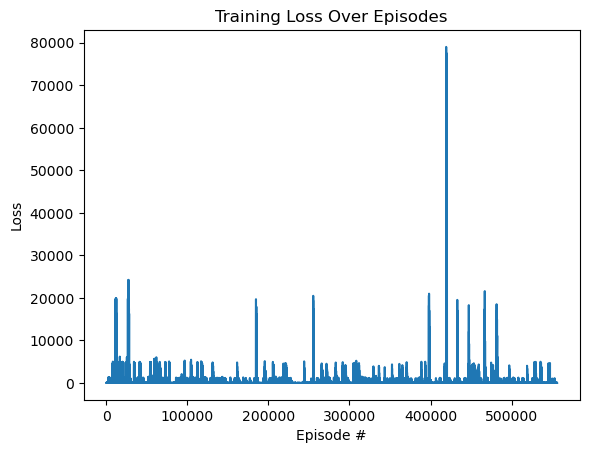

In [22]:
training_loss = []

for episode in tqdm(range(n_episodes)):
    frame, info = env.reset()
    frame = preprocess_frame(frame)
    done = False
    
    # Reset the stacked frames at the beginning of each episode
    stacked_frames = deque([frame for _ in range(4)], maxlen=4)          
    state = np.stack(stacked_frames, axis=0)  # (4, 84, 84)
    state = torch.from_numpy(state).float().unsqueeze(0).to(device) # (1,4,84,84) tensor
    
    while not done:
        action = agent.select_action(state, explore=True)
        
        next_frame, reward, terminated, truncated, info = env.step(action)
        
        next_frame = preprocess_frame(next_frame)
        stacked_frames.append(next_frame)
        next_state = np.stack(stacked_frames, axis=0) # (4, 84, 84)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device) # (1,4,84,84) tensor
        
        done = terminated or truncated
        
        experience = (state, action, reward, next_state, done)
        agent.replay_buffer.add(experience)
        
        loss = agent.train()
        if loss is not None:
            training_loss.append(loss)
    
        state = next_state
        
    if episode != 0 and episode % update_frequency == 0:
        agent.target_network.load_state_dict(agent.primary_network.state_dict())
        agent.save_checkpoint(f"checkpoint_episode_{episode}.pth")
            
        average_loss = sum(training_loss[-update_frequency:]) / update_frequency
        print(f"Episode {episode}, Average Loss: {average_loss}")
            
        agent.evaluate(n_eval_episodes=10)
        
    agent.decay_epsilon()

plt.plot(training_loss)
plt.title("Training Loss Over Episodes")
plt.xlabel("Episode #")
plt.ylabel("Loss")
plt.show()

In [27]:
agent.evaluate(n_eval_episodes=1, render_mode="human")

Average Reward Over 1 Episodes: 370.0

